# This sample is used to demonstrate horizontal integration.

### Step 0：Since Jupyter Notebook does not automatically release GPU memory after running, please run this code to clear all processes occupying GPU memory before the FIRST time starting execution.¶

In [1]:
!fuser -v /dev/nvidia* |awk '{for(i=1;i<=NF;i++)print "kill -9 " $i;}' | sh

Cannot stat file /proc/1127691/fd/0: Permission denied
Cannot stat file /proc/1127691/fd/1: Permission denied
Cannot stat file /proc/1127691/fd/2: Permission denied
Cannot stat file /proc/1127691/fd/3: Permission denied
Cannot stat file /proc/1127691/fd/4: Permission denied
Cannot stat file /proc/1127691/fd/5: Permission denied
Cannot stat file /proc/1127691/fd/8: Permission denied
Cannot stat file /proc/1127716/fd/0: Permission denied
Cannot stat file /proc/1127716/fd/1: Permission denied
Cannot stat file /proc/1127716/fd/2: Permission denied
Cannot stat file /proc/1127716/fd/3: Permission denied
Cannot stat file /proc/1127716/fd/4: Permission denied
Cannot stat file /proc/1127716/fd/5: Permission denied
Cannot stat file /proc/1127716/fd/8: Permission denied
Cannot stat file /proc/1127736/fd/0: Permission denied
Cannot stat file /proc/1127736/fd/1: Permission denied
Cannot stat file /proc/1127736/fd/2: Permission denied
Cannot stat file /proc/1127736/fd/3: Permission denied
Cannot sta

### Step 1 Load packages

In [2]:
import argparse
import os
os.chdir('/remote-home/13186919777/home/STAIG-test')
import warnings
warnings.filterwarnings('ignore')
import random
import yaml
from yaml import SafeLoader
import torch
from staig.adata_processing import LoadBatch10xAdata
import numpy as np
from staig.staig import STAIG
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt

### Step 2: Load data and train

In [3]:

file_fold = './Dataset'


args = argparse.Namespace(
    dataset='visium',
    slide='integration_horizontal',
    config='train_img_config.yaml',
    label=False,
    filelist=['Mouse_Brain_Anterior', 'Mouse_Brain_Posterior']
)

config = yaml.load(open(args.config), Loader=SafeLoader)[str(args.slide)]
slide_path = os.path.join(file_fold, args.dataset)

torch.manual_seed(config['seed'])
np.random.seed(config['seed'])
if torch.cuda.is_available():
    torch.cuda.manual_seed(config['seed'])
    torch.cuda.manual_seed_all(config['seed'])
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
random.seed(12345)

data = LoadBatch10xAdata(dataset_path=slide_path,file_list = args.filelist,n_neighbors=config['num_neigh'],n_top_genes=config['num_gene'],image_emb=False, label = args.label).run()
staig = STAIG(args=args,config=config,single=True,refine=False)    
staig.adata = data
staig.train()
staig.eva()


now load: Mouse_Brain_Anterior
Mouse_Brain_Anterior build local graph done
Mouse_Brain_Anterior added to list
now load: Mouse_Brain_Posterior
Mouse_Brain_Posterior build local graph done
Mouse_Brain_Posterior added to list
load all slices done
merge done
now calculate edge weights
calculate edge weights done
merge adata load done
=== prepare for training ===
=== train ===


100%|██████████| [00:01<00:00, 12.77it/s]


=== load ===
embedding generated, go clustering


### Step4: Clustering

In [4]:
staig.cluster(args.label)
rgb_values = sns.color_palette("tab20", len(staig.adata.obs['domain'].unique()))
color_fine = dict(zip(list(staig.adata.obs['domain'].unique()), rgb_values))

fitting ...
  |======================================================================| 100%
calculate SC and DB
SC: 0.13612212
DB: 1.7411332786879632
BatchKL= [0.8057015]
Median ILISI: 1.03


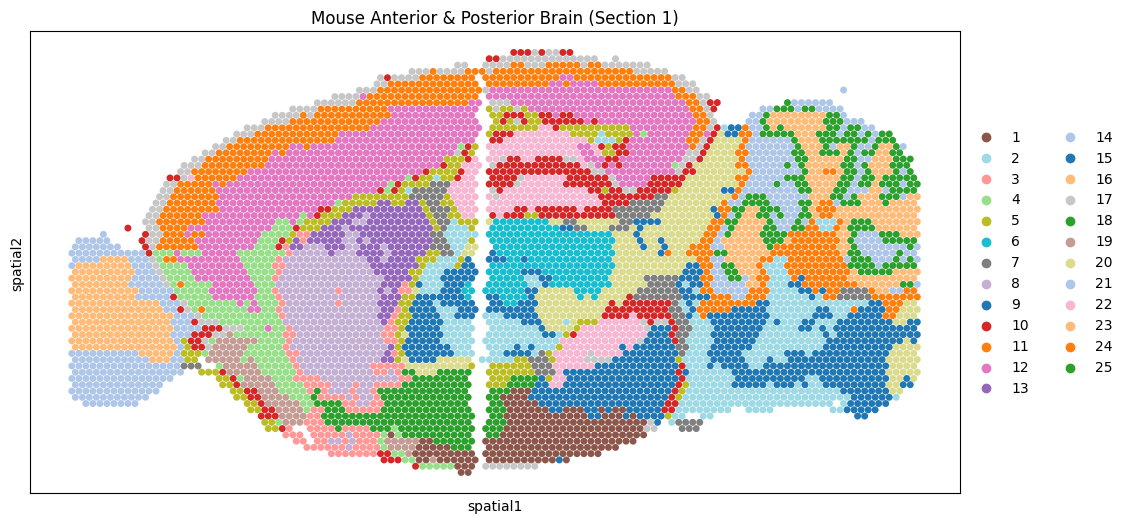

In [5]:
plt.rcParams["figure.figsize"] = (12, 6)
data_all = sc.read_h5ad('./Dataset/9.Mouse_Brain_Merge_Anterior_Posterior_Section_1/filtered_feature_bc_matrix.h5ad') #It merely utilizes already aligned coordinates for better demonstration.
data_all.obsm['spatial'][:,1] = -1*data_all.obsm['spatial'][:,1]
staig.adata.obsm['spatial']=data_all.obsm['spatial']
sc.pl.embedding(staig.adata, basis="spatial",
                    color="domain",
                    s=100,
                    show=True,
                    palette=color_fine,
                    title='Mouse Anterior & Posterior Brain (Section 1)')

# UMAP

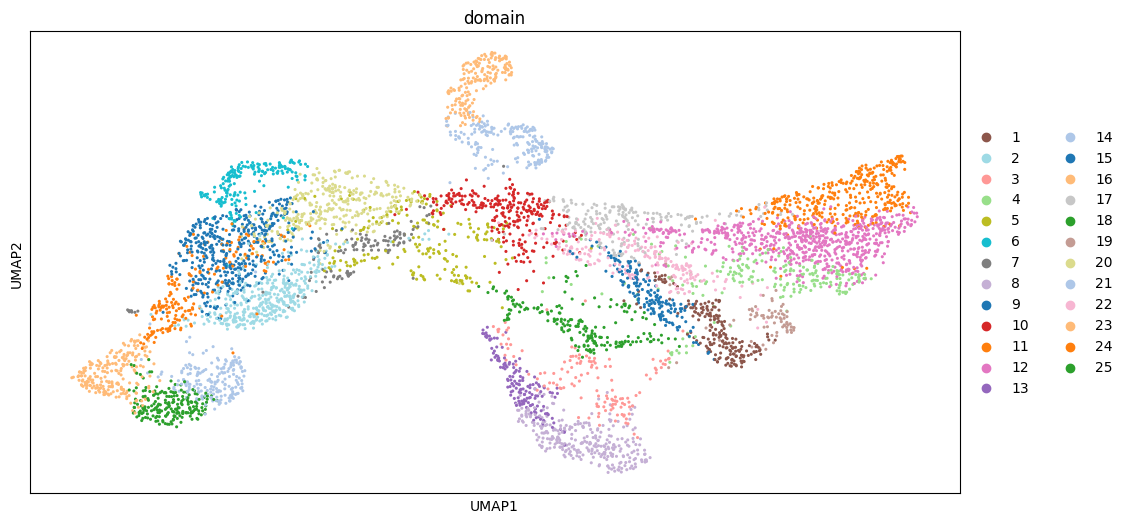

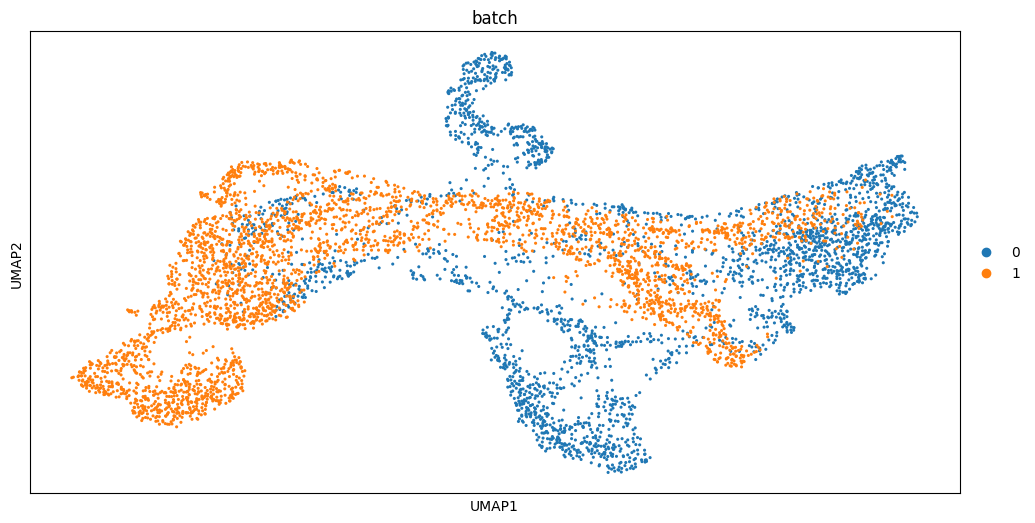

In [6]:
sc.pp.neighbors(staig.adata, use_rep='norm_emb')
sc.tl.umap(staig.adata)
sc.pl.umap(staig.adata, color='domain',palette=color_fine, show=True)
sc.pl.umap(staig.adata, color='batch', show=True)